# Классификация в SKTime


Классификация временных рядов и другие, связанные задачи являются значимой частью задач анализ временных рядов. Отметим, что к [связанным с классификацией](https://timeseriesclassification.com/index.php) так или иначе относятся все supervised data-driven задачи анализ временных рядов.

Задачи классификации временных рядов (<tt>Time series classification, TSC</tt>) включают в себя подгонку модели из непрерывной (в широком смысле) упорядоченной последовательности наблюдений (временного ряда) к дискретной переменной отклика (классу). Временные ряды могут быть одномерными (одна переменная, наблюдаемая в каждый момент времени, <tt>UTSC</tt>) или многомерными (несколько переменных, наблюдаемых в каждый момент времени, <tt>MTSC</tt>). 


Проблемы с <tt>TSC</tt> возникают в самых разных областях, например задачи классификации с использованием: электроэнцефалограмм; электрокардиограмм; типа дейятельности человека по массивам координат его перемещения (<tt>HAR</tt>) и других данных; контуров изображений; спектрограмм; других по-сути одномерных кривых; аудиозапясях и сигналах; уровнях трафика и пешеходов;  и смоделированные данные. 

Исследования <tt>TSC</tt> характеризуются огромным разнообразием проблемных областей. Первоначальный вопрос
при сравнении алгоритмов для TSC заключается в том, можем ли мы сделать какие-либо ориентировочные выводы о производительности в широком спектре задач без каких-либо предварительных
знаний о лежащей в основе общей структуре данных. 

> Отметим, что технически можно говорить о двух подходах к классификации временных рядов: классическом, имеющем длинную предысторию; и  современном, вдонавленном успехами в области машинного обучения. Мы будем говорить о втором подходе. Этот подхдод сравнительно недавний, [его можно отнести к периоду с 2017 года](https://arxiv.org/pdf/2304.13029.pdf).

> Также важно отметить, что из-за временной структуры исходных данных стандартные алгоритмы машинного обучения обычно [не очень хорошо подходят](https://inria.hal.science/hal-03558165/document) для работы с [необработанными временными рядами](https://tsfel.readthedocs.io/en/latest/descriptions/get_started.html).


Также отметим, что часто анализ перспективности тех или иных алгоритмов классификации ВР строится на несколькоих наборах данных - бенчамарках, среди которых наиболее популярным явялется [<tt>UCR archive</tt>](https://www.cs.ucr.edu/%7Eeamonn/time_series_data_2018/). Кроме того отметим, что в силу молодости сообщества вебсайт <tt>https://timeseriesclassification.com/</tt>, старатется собрать все последние достижения в этой сфере. 

<!-- Экспериментальная оценка алгоритмов классификации временных рядов, которую мы отныне будем называть тестированием, была проведена в 2016 году и опубликована в 2017 году (Bagnall
et al., 2017). Этот успех в сочетании с перезапуском архивов классификации временных рядов
(Dau et al., 2019) помог повысить интерес к алгоритмам
и приложениям TSC. -->

<!-- К задачам такого типа могут относится, например, задачи классификации животных по аудиосигналу их звуков (напр.  классификация видов китов по их крикам). 
данные о координатах отслеживания движения могли бы представлять собой многомерный времянной ряд в задаче распознавания человеческой деятельности (HAR).
 -->

## Импорт библиотек

Начнем с импорта нужных библиотек

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
try:
    import sktime
except:
    !pip install sktime --user
    !pip install tsfresh 
    !pip install numba
    !pip install llvmlite
finally:
    import sktime

In [3]:
from sktime.classification.kernel_based import RocketClassifier

In [4]:
from sktime.datasets import load_from_tsfile
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

In [5]:
import warnings
from statsmodels.tools.sm_exceptions import ConvergenceWarning
warnings.simplefilter('ignore', category=ConvergenceWarning)
warnings.simplefilter('ignore', category=FutureWarning)
warnings.simplefilter('ignore', category=NotImplementedError)
warnings.simplefilter('ignore', category=UserWarning)

## Импорт данных

Теперь выберем набор данных. Для нашего урока мы воспользуемся уже имеющимся набором данных [открытые данные энергетических систем](https://open-power-system-data.org/). 

Пересоздадим набор данных с часовым шагом. [Можно перейти к отрытию набора, если он уже создан](######-Если-набор-уже-создан-можно-перейти-к-его-открытию)

In [6]:
import ssl
ssl._create_default_https_context = ssl._create_stdlib_context

In [7]:
url = 'https://data.open-power-system-data.org/time_series/2020-10-06/'
datafile = url + 'time_series_60min_singleindex.csv'
df_all = pd.read_csv(datafile, index_col='utc_timestamp', parse_dates=True, low_memory=False)

Также как и ранее выберем нужную страну, для примеров это была Германия.

In [8]:
def extract_country(df_all, country_code, year_min=None, year_max=None):
    """Extract data for a single country"""
    
    # List of columns to extract
    columns = [col for col in df_all.columns if col.startswith(country_code)]
    
    # Extract columns and remove country codes from column labels
    columns_map = {col : col[3:] for col in columns}
    df_out = df_all[columns].rename(columns=columns_map)
    
    # Exclude years outside of specified range, if any
    if year_min is not None:
        df_out = df_out[df_out.index.year >= year_min]
    if year_max is not None:
        df_out = df_out[df_out.index.year <= year_max]
        
    return df_out

def transform_dataframe(df, cols_map):
    # Rename columns for convenience
    df = df[list(cols_map.keys())].rename(columns=cols_map)
    # Convert from MW to GW
    df = df / 1000
#     df = df.groupby(df.index.hour).mean()
    df = df.rename_axis('Date')
#     df.index = df.index.strftime('%Y-%m-%d-%h')
    return df

In [9]:
df_hrly = extract_country(df_all, country_code='DE', year_min=2015, year_max=2019)
df_hrly.sample(3)

cols_map = {'load_actual_entsoe_transparency' : 'Consumption',
            'wind_generation_actual' : 'Wind',
            'solar_generation_actual' : 'Solar'}
df = transform_dataframe(df_hrly, cols_map).dropna()

# df wind + solar generation
df['Wind+Solar'] = df[['Wind', 'Solar']].sum(axis=1, skipna=False)
df.index = df.index.strftime('%Y-%m-%d-%H')
df.to_csv('de_clf_data.csv')

df.head()

,Consumption,Wind,Solar,Wind+Solar
Date,,,,
2015-01-01-07,41.133,10.208,0.071,10.279
2015-01-01-08,42.963,10.029,0.773,10.802
2015-01-01-09,45.088,10.550,2.117,12.667
2015-01-01-10,47.013,11.390,3.364,14.754
2015-01-01-11,48.159,12.103,4.198,16.301


###### Если набор уже создан можно перейти к его открытию

In [10]:
df = pd.read_csv('de_clf_data.csv')
df.Date = pd.to_datetime(df.Date)
df.set_index('Date', inplace=True)
df.index = pd.to_datetime(df.index.strftime('%Y-%m-%d-%H'))
df

,Consumption,Wind,Solar,Wind+Solar
Date,,,,
2015-01-01 07:00:00,41.133,10.208,0.071,10.279
2015-01-01 08:00:00,42.963,10.029,0.773,10.802
2015-01-01 09:00:00,45.088,10.550,2.117,12.667
2015-01-01 10:00:00,47.013,11.390,3.364,14.754
2015-01-01 11:00:00,48.159,12.103,4.198,16.301
...,...,...,...,...
2019-12-31 19:00:00,47.493,8.875,0.000,8.875
2019-12-31 20:00:00,45.842,7.652,0.000,7.652
2019-12-31 21:00:00,45.501,7.283,0.000,7.283


In [11]:
print(df.index.year)

Index([2015, 2015, 2015, 2015, 2015, 2015, 2015, 2015, 2015, 2015,
       ...
       2019, 2019, 2019, 2019, 2019, 2019, 2019, 2019, 2019, 2019],
      dtype='int32', name='Date', length=43719)


Для текущей цели - изучить классификацию временных рядов давайте сделаем набор данных с классами. Для этого предлагается поставить задачу определение по дневному потреблению сезона (зима, весна, осень, лето):
* Разделить все данные на 4 сезона (зима, весна, осень, лето)
* взять данные с шагом 1 час.
* создать сегменты размером 24 часа (1 день).

Данная задача полностью искусственная, однако в целом соответствует некоторым из задачи стандартных тестов классификации временных рядов, например [смотрите тут](http://www.timeseriesclassification.com/description.php?Dataset=PowerCons). 

Напомним, что для проведения классификации, как правило, данные следует разделять на сегменты.  Как правило, эти сегменты не должны пересекаться. В нашем случае длина сегмента будет 24 точки.

Для цели создания набора данных давайте создадим 2 функции, первая `split_by_month` будет разделять наш набор данных на месяца. Вторая функция `to_segments` будет создавать сегменты по 24 часа в сутках.

In [12]:
def split_by_month(df, months):
    df_ = pd.DataFrame()
    for month in np.atleast_1d(months):        
        df_ = pd.concat([df_,df.loc[df.index.month == month]])
    return df_

def to_segments(df, column, size = 24):  
    df.index.hour[0]
    start_idx = 24-df.index.hour[0]
    df = df.iloc[start_idx:]
    val = df[[column]].values
    return val[:size*(val.size//size)].reshape(-1,size)

In [13]:
winter = to_segments(split_by_month(df, [1,2, 12]), 'Consumption', size = 24)
summer = to_segments(split_by_month(df, [6, 7, 8]), 'Consumption', size = 24)
autumn = to_segments(split_by_month(df, [9,10,11]), 'Consumption', size = 24)
spring = to_segments(split_by_month(df, [3, 4, 5]), 'Consumption', size = 24)
print(winter.shape, summer.shape, autumn.shape, spring.shape)

(448, 24) (458, 24) (452, 24) (458, 24)


Теперь мы создали 4 класса. Давайте посмотрим как выглядят их примеры.

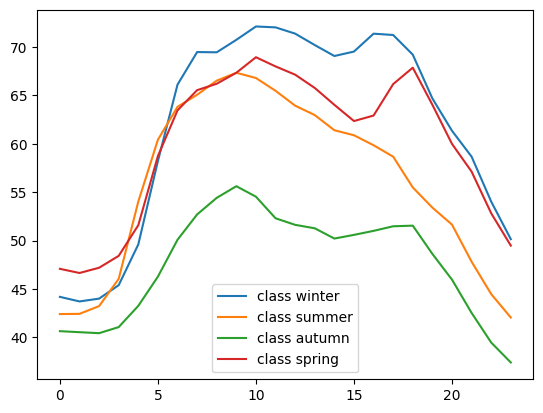

In [14]:
plt.figure()
day = 10
for i,(c,d) in enumerate(zip([winter,summer,autumn,spring],['winter','summer','autumn','spring'])):
    plt.plot(c[day], label="class " + str(d))
plt.legend(loc="best")
plt.show()
plt.close()

Хотя примеры показывают  высокую степень сходства мы все же попробуем их классифицировать. Для этого создадим массив тренировочных и тестовых данных.

In [15]:
X = np.concatenate((
                    winter, 
                    summer, 
                    autumn, 
                    spring))
y = np.concatenate((
                    0*np.ones(winter.shape[0]),
                    1*np.ones(summer.shape[0]),
                    2*np.ones(autumn.shape[0]),
                    3*np.ones(spring.shape[0])
                   ))
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(1271, 24) (1271,) (545, 24) (545,)


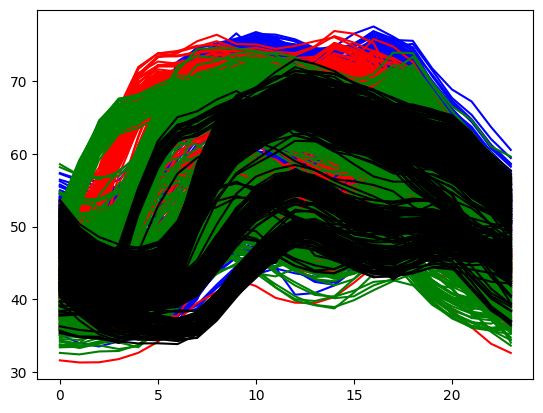

In [16]:
[plt.plot(X[i], c= 'b') for i in range(len(X)) if y[i]==0];
[plt.plot(X[i], c= 'r') for i in range(len(X)) if y[i]==2];
[plt.plot(X[i], c= 'g') for i in range(len(X)) if y[i]==3];
[plt.plot(X[i], c= 'k') for i in range(len(X)) if y[i]==1];


Не понятно к какому из подходов относится данная задача. Предполагаем, что не к подходу временной схожести. Хотя некоторые признаки, например максимальное значение возможно и различимы.

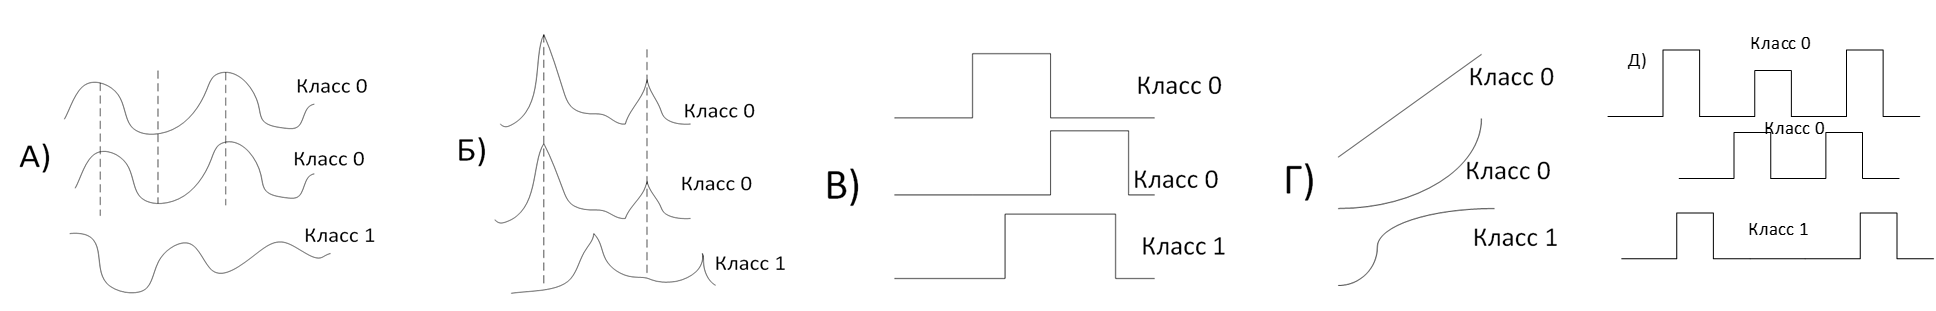

Современная версия `SKTime` [допускает](https://github.com/sktime/sktime/blob/main/examples/loading_data.ipynb) формат массивов в виде `2d ndarray (numpy)` для однопеременных временных рядов. Для многопеременных временных рядов массив может быть задан в виде `3d ndarray`. В общем случае однопеменный ряд также может быть задан как многопеременный с размерностью массива $\text{samples} \times \text{variable} \times \text{segment}$ Также в пакете `SKTime` предусмотрены и другие форматы. В том числе специализированные. Для преобразования между форматами используются [`convert`](https://www.sktime.net/en/stable/api_reference/auto_generated/sktime.datatypes.convert.html) и [`convert_to`](https://www.sktime.net/en/stable/api_reference/auto_generated/sktime.datatypes.convert_to.html) из модуля [`sktime.datatypes`](https://github.com/sktime/sktime/blob/main/examples/AA_datatypes_and_datasets.ipynb). Например, для преобразования двухмерного массива во встроенный однопеременных формат можно воспользоваться следующим скриптом
```python
    df = convert_to(np.atleast_3d(X).transpose(0,2,1), to_type="nested_univ") 
```
Однако  не все функции `SKTime` поддерживают `2d ndarray` поэтому давайте создадим [`nested_univ`](https://www.sktime.net/en/stable/examples/AA_datatypes_and_datasets.html) копии данных.

In [17]:
from sktime.datatypes import convert_to
df_train = convert_to(np.atleast_3d(X_train).transpose(0,2,1), to_type="nested_univ") 
df_test  = convert_to(np.atleast_3d(X_test ).transpose(0,2,1), to_type="nested_univ") 

## Классификация sklearn

Перед тестированием специализированных методов из пакета `SKTime` давайте посмотрим на результаты стандартных подходов из `sklearn`. В анализе временных рядов среди таких стандартных подходов наиболее распространен [`случайный лес`](https://machinelearningmastery.com/random-forest-for-time-series-forecasting/). Также давайте попробуем алгоритм `k-соседей` с евклидовым расстоянием как некоторую предварительную базовую оценку.

In [18]:
from sklearn.ensemble  import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

clf = RandomForestClassifier(n_estimators=100)
clf.fit(X_train, y_train)
print(f' test score {clf.score(X_test, y_test):.3f}')


 test score 0.892


In [19]:
clf = KNeighborsClassifier(n_neighbors=1)
clf.fit(X_train, y_train)
print(f' test score {clf.score(X_test, y_test):.3f}') 

 test score 0.879


## Классификаторы ВР на основе данных

В теоретической части мы уже обсуждали типы алгоритмов классификации временных рядов. Теперь давайте попробуем их на практике. Ранее мы обсуждали что в качестве некоторой базовой оценки можно использовать [**`1-NN DTW`**](https://github.com/markdregan/K-Nearest-Neighbors-with-Dynamic-Time-Warping) классификатор. Напомним, что этот подход сравнивает [схожесть временных рядов](https://www.aeon-toolkit.org/en/latest/examples/similarity_search/similarity_search.html) "в целом". Расстояние [`DTW`](https://rtavenar.github.io/blog/dtw.html) относится к эластичным мерам, стабильным к искажениям различных сегментов ряда. Иллюстрацию метода можно найти в следующем виде:
<!-- <img src="https://www.aeon-toolkit.org/en/latest/_images/DTW_GUI_warped.gif" width="600"> -->
<img src="https://rtavenar.github.io/blog/fig/dtw_path_matrix.svg" width="600">


В пакете `SKTime`  тип [k-соседей](https://www.sktime.net/en/stable/api_reference/auto_generated/sktime.classification.distance_based.KNeighborsTimeSeriesClassifier.html) алгоритмов находится в модуле [`distance_based`](https://www.aeon-toolkit.org/en/latest/examples/classification/distance_based.html).

In [20]:
from sktime.classification.distance_based import KNeighborsTimeSeriesClassifier
clf = KNeighborsTimeSeriesClassifier(n_neighbors=1, distance="dtw")
clf.fit(X_train, y_train)
print(f' test score {clf.score(X_test, y_test):.3f}')

 test score 0.839


Полученный результат не превзошёл результат с евклидовым расстоянием. Вероятно, это связано с близостью форм сегментов. Однако [`1-NN DTW`](https://www.theaidream.com/post/dynamic-time-warping-dtw-algorithm-in-time-series) [может быть реализован](https://pyts.readthedocs.io/en/stable/auto_examples/metrics/plot_dtw.html#sphx-glr-auto-examples-metrics-plot-dtw-py) и в более [продвинутых формах](https://tslearn.readthedocs.io/en/latest/user_guide/dtw.html#examples-involving-dtw-variants). Одной из таких форм является [расстояние разностей](https://timeseriesclassification.com/algorithmdescription.php?algorithm_id=114) [`ddtw`](https://www.sktime.net/en/stable/api_reference/auto_generated/sktime.distances.ddtw_distance.html). 

> Дополнительно укажем возможность использования матриц `DTW` и их модификаций в сторонних библиотеках, в том числе в качестве результатов ядерных преобразований [(напр. в методе опорных векторов)](https://www.aeon-toolkit.org/en/latest/examples/distances/sklearn_distances.html).

In [21]:
from sktime.classification.distance_based import KNeighborsTimeSeriesClassifier

clf = KNeighborsTimeSeriesClassifier(n_neighbors=1, distance="ddtw")
clf.fit(X_train, y_train)
print(f' test score {clf.score(X_test, y_test):.3f}')

 test score 0.917


Другим вариантом классификатора на основе данных являются  [**Шейплет преобразования**](https://tslearn.readthedocs.io/en/stable/user_guide/shapelets.html) (и соответствующие им shapelet classifier). Напомним, что [шейплет](https://pyts.readthedocs.io/en/stable/auto_examples/transformation/plot_shapelet_transform.html#sphx-glr-auto-examples-transformation-plot-shapelet-transform-py) представляет собой участок временного ряда, обладающий [наибольшей дискриминационной способностью для задачи](https://timeseriesclassification.com/algorithmdescription.php?algorithm_id=110). Другими словами, **для участков - шейплетов различия между классами наиболее существенны**.

<img src="https://www.researchgate.net/profile/Monica-Arul/publication/340883818/figure/fig1/AS:883686908116992@1587698785921/Time-series-shapelets_W640.jpg" style="width:600px">

Классификаторы [на основе шейплетов](https://pyts.readthedocs.io/en/stable/auto_examples/transformation/plot_shapelet_transform.html#sphx-glr-auto-examples-transformation-plot-shapelet-transform-py) позволяют найти наиболее различающиеся паттерны в данных. 



В ракете `SKTime` шейплеты могут быть найдены в модуле [`sktime.classification.shapelet_based`](https://www.sktime.net/en/latest/api_reference/auto_generated/sktime.classification.shapelet_based.ShapeletTransformClassifier.html).

In [22]:
from sktime.classification.shapelet_based import ShapeletTransformClassifier

clf = ShapeletTransformClassifier(estimator=RandomForestClassifier(n_estimators=100),
                                  n_shapelet_samples=100,
                                  max_shapelets=100,
                                  batch_size=20)

clf.fit(X_train, y_train)
print(f' test score {clf.score(X_test, y_test):.3f}')

 test score 0.919


Отметим, что к результатам шейплет-преобразований как таковых могут быть применены и [другие алгоритмы классификации временных рядов](https://www.aeon-toolkit.org/en/latest/examples/classification/distance_based.html#Shape-Dynamic-Time-Warping:-ShapeDTW-in-aeon.) как к независимым сегментам ВР. Другими словами стоит выделять отдельно [шейплет-преобразование](https://www.aeon-toolkit.org/en/latest/examples/classification/shapelet_based.html)  и отдельно классификатор, который его включает.

Как обсуждалось в теоретической части в ряде случаев более полезным оказываться повторяемость такие паттернов.  В таких и подобных задачах для описания временных рядов (для их представления) могут быть использованы **подходы на основе т.н. словаря** [(**Dictionary-based**)](https://www.aeon-toolkit.org/en/latest/examples/classification/dictionary_based.html). 

Напомним, что словаи могут формроваться как [некоторое загрубление](https://pyts.readthedocs.io/en/stable/auto_examples/bag_of_words/plot_bow.html#sphx-glr-auto-examples-bag-of-words-plot-bow-py) сегмента ВР или его частей.
<img src="https://github.com/lnthach/Mr-SEQL/raw/master/figs/sax_demo.png" width="600">



Подходы, [основанные на словарях](https://www.aeon-toolkit.org/en/stable/examples/classification/dictionary_based.html), адаптируют [*модель мешка слов*](https://pyts.readthedocs.io/en/stable/modules/bag_of_words.html), широко используемую в обработке сигналов, компьютерном зрении и обработке звука, для классификации временных рядов. Как и алгоритмы, основанные на шейплетах, словарные подходы используют независимые подпоследовательности, полученные путем скольжения окна по временному ряду. Однако вместо того, чтобы измерять расстояние до подпоследовательности (как в шейплетах) каждое окно преобразуется в слово, и регистрируется частота появления повторяющихся паттернов. Алгоритмы, работающие по словарной модели, строят классификатор следующим образом:
* Извлечения подсерий, путем называемых окон, из временного ряда
* Преобразования каждого окна вещественных значений в дискретно-значное слово (последовательность символов в фиксированном алфавите);
* Построение разреженного вектора признаков из гистограмм количества слов; 
* использование метода классификации из репертуара машинного обучения на этих векторах признаков. 

В пакете [`SKTime`](https://www.sktime.net/en/stable/examples/classification/dictionary_based_classification.html) для работы со словарями используется модуль [`sktime.classification.dictionary_based`](https://www.sktime.net/en/stable/examples/classification/dictionary_based_classification.html). 

Мы рассмотрим несколько методов на основе словарей:
* метод __BOSS__ [один из наиболее](https://link.springer.com/article/10.1007/s10618-014-0377-7) популярных методов. Он основан на ансамблирование индивидуальных классификаторов BOSS (IndividualBOSS), использующих преобразование [SFA](https://github.com/patrickzib/SFA?tab=readme-ov-file#sfa-symbolic-fourier-approximation). Классификатор выполняет сеточный поиск по большому числу параметров классификаторв. В итоге оставляют лишь те, для которых точность не ниже 92% от наилучшего. В качестве метода приниятия решний тут используется к-сосседей, но с оригальной функцией расстояния. Особенность тут в том, что SFA символы - это частотные представления сигнала. Таким образом итогом работы алагоритма становится представления [символьного описания для набора частот](https://pyts.readthedocs.io/en/stable/auto_examples/transformation/plot_boss.html#sphx-glr-auto-examples-transformation-plot-boss-py). Мы воспользуемся тут [лишь индивидуальным  классификатором](https://www.sktime.net/en/v0.14.0/api_reference/auto_generated/sktime.classification.dictionary_based.IndividualBOSS.html) для того, чтобы не тратить на это много времени. Отметим, также что для оригинального алгоритма BOSS могут быть и [другие модификации](https://www.sktime.net/en/stable/examples/classification/dictionary_based_classification.html#4.-Contractable-BOSS-(cBOSS)). 
* Среди модификаций BOSS мы рассмотрим вариант [__Temporal Dictionary Ensemble__](https://www.sktime.net/en/stable/examples/classification/dictionary_based_classification.html#6.-Temporal-Dictionary-Ensemble-(TDE)). Этот вариант включает Объеденение нескольких репрезентаций ВР, в т.ч. BOSS. Для экономии времени мы рассмотрим лишь одну из таких вариаций [IndividualTDE](https://www.sktime.net/en/stable/api_reference/auto_generated/sktime.classification.dictionary_based.IndividualTDE.html).
* [__MUSE (MUltivariate Symbolic Extension) (WEASLE-MUSE)__](https://github.com/patrickzib/SFA?tab=readme-ov-file#weaselmuse-weasel--multivariate-symbolic-extension) также является расширением идеи SFA описания временонго ряда. В оригинальном [WEASLE](https://arxiv.org/abs/1701.07681)  используются модификация SFA и метод контролируемого отбора признаков ANOVA. В упрощенной версии алгроитма -  [MUSE](https://arxiv.org/abs/1711.11343) контролирумый отбор убран так как [ведет с переобучению модели](https://github.com/patrickzib/SFA?tab=readme-ov-file#weaselmuse-weasel--multivariate-symbolic-extension).

  Отметим также особенность [SFA симолов](https://www.aeon-toolkit.org/en/stable/examples/classification/dictionary_based.html):
 - Значения в каждом окне нормируются так, чтобы стандартное отклонение было равно 1.
 - подсерия окна преобразуется с помощью быстрого преобразования Фурье, и сохраняются только первые несколько коэффициентов.
 - Каждый коэффициент дискретизируется в символ из алфавита фиксированного размера, [образуя слово](https://inria.hal.science/hal-03558165/document) c использоованием специальной [техники MCB](https://pyts.readthedocs.io/en/stable/auto_examples/approximation/plot_mcb.html).

    <img src="https://www.researchgate.net/publication/364183900/figure/fig5/AS:11431281088241095@1665022203156/A-pictorial-diagram-of-symbolic-Fourier-approximation-SFA-procedure-a-Incoming-sensor.png" style="width:500px">

In [23]:
from sktime.classification.dictionary_based import (ContractableBOSS, 
                                                    IndividualBOSS, 
                                                    IndividualTDE, 
                                                    MUSE, WEASEL)

In [24]:
clf = IndividualBOSS(random_state=47)
clf.fit(X_train, y_train)
clf.score(X_test, y_test)

0.7577981651376147

In [25]:
clf = IndividualTDE(random_state=47)
clf.fit(X_train, y_train)
clf.score(X_test, y_test)

0.8403669724770643

In [26]:
clf = MUSE(random_state=47)
clf.fit(X_train, y_train)
clf.score(X_test, y_test)

0.963302752293578

## Классификаторы на основе признаков

Классификаторы, рассмотрены выше можно было отнести к т.н. классификаторам на основе данных. Однако как уже обсуждалось в теоретической части, часто следует отдавать предпочтения классификаторам на основе признаков. Одними из наиболее популярных подходов среди таких классификаторов являются интервальные подходы. Суть таких подходов сводится к
* поиску или случайному выбору интервалов внутри временных рядов;
* извлечению некоторого набора признаков для такого интервала;
* построению некоторого классификатора, например, дерева для каждого интервала;
* объединение результатов для всех интервалов, например, при помощи леса деревьев.

В пакете `SKTime` такие методы могут быть найдены в модуле [`sktime.classification.interval_based`](https://www.sktime.net/en/stable/examples/classification/interval_based_classification.html).

Мы рассмотрим несклько вариантов таких классификаторов. В некотором смысле все из рассматриваемых классификаторов этого типа относятся и к классификаторам на основе ансамблей деревьев. Однако тут такие ансамбли отличаются от классических алгоритмов. Среди методов интервальной классификации мы рассмотрим следующие:
* __Лес временных рядов__ [(Time series forest, TSF)](https://www.timeseriesclassification.com/algorithmdescription.php?algorithm_id=5). Алгоритм [TSF](https://www.aeon-toolkit.org/en/latest/examples/classification/interval_based.html#3.-Time-Series-Forest-(TSF)) - это совокупность классифицирующих деревьев, построенных на основе сводных статистик случайно выбранных интервалов сегмента ВР. Для каждого дерева случайным образом выбираются [`sqrt(series_length)`](https://www.sktime.net/en/stable/api_reference/auto_generated/sktime.classification.interval_based.TimeSeriesForestClassifier.html) интервалов. Из каждого из этих интервалов извлекаются: среднее значение, стандартное отклонение и наклон линейного тренда. Значения объединяются в вектор признаков. Эти новые признаки затем используются для построения дерева, которое добавляется к ансамблю. В оригинальной работе также используется свой алгоритм разщипления деревьев.
* __RISE__ [(Random Interval Spectral Ensemble)](https://www.sktime.net/en/latest/examples/classification/interval_based_classification.html#4.-Random-Interval-Spectral-Ensemble-(RISE)) - это ансамбль а основе деревьев. В отличие от `TSF`, он использует один интервал для каждого дерева и использует широкий набор спектральные характеристики в качестве вектора, а не сводную статистику. Изначально метод планировался  для классификации аудиоданных. Имеются также [и модификации модели](https://link.springer.com/chapter/10.1007/978-3-030-29859-3_33).
* __SupervisedTimeSeriesForest__ как некоторый метод [модификации временного леса](https://www.aeon-toolkit.org/en/latest/examples/classification/interval_based.html#5.-Supervised-Time-Series-Forest-(STSF)), который включает контролируемый метод выбора интервалов, а также расширяет набор признаков. 

In [27]:
# from sktime.classification.interval_based import RSTSF
from sktime.classification.interval_based import SupervisedTimeSeriesForest
from sktime.classification.interval_based import TimeSeriesForestClassifier
from sktime.classification.interval_based._rise import RandomIntervalSpectralEnsemble

In [28]:
clf = TimeSeriesForestClassifier(n_estimators=100,random_state=47)
clf.fit(X_train, y_train)
print(f' test score {clf.score(X_test, y_test):.3f}')

 test score 0.947


In [29]:
clf = RandomIntervalSpectralEnsemble(n_estimators=100, random_state=47)
clf.fit(X_train, y_train)
print(f' test score {clf.score(X_test, y_test):.3f}')

 test score 0.934


In [30]:
clf = SupervisedTimeSeriesForest(n_estimators=100, random_state=47)
clf.fit(X_train, y_train)
print(f' test score {clf.score(X_test, y_test):.3f}')

 test score 0.947


Помимо алгоритмов на основе деревьев, популярным на сегодня является [методы на основе ядерных преобразований](https://www.aeon-toolkit.org/en/latest/examples/classification/convolution_based.html). Одним из наиболее успешных алгоритмов в этом направлении является алгоритм **`ROCKET`**. Суть данного алгоритма сводится к трансформации данных при помощи набора сверточных ядре со случайно выбранными параметрами. Затем авторы рекомендуются использовать  [`RidgeClassifierCV`](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.RidgeClassifierCV.html), который предоставляет собой Логистическую регрессию с `L2` регуляризацией, параметр регуляризации выбирается при помощи кросс-валидации. 

<!-- Мы рассмотрим [ускоренную версию](https://www.aeon-toolkit.org/en/latest/examples/transformations/minirocket.html) преобразования [`MiniRocket`](https://github.com/sktime/sktime/blob/main/examples/minirocket.ipynb).  -->

>Отметим, что преобразования `ROCKET` могут также быть использованы отдельно от классификаторов [в качестве генератора признакового пространства](https://www.sktime.net/en/latest/examples/transformation/rocket.html).

In [31]:
from sktime.classification.kernel_based import RocketClassifier

clf = RocketClassifier(num_kernels=1000) 
clf.fit(X_train, y_train)

clf.fit(Xt_train, y_train)
print(f' test score {clf.score(Xt_test, y_test):.3f}')

NameError: name 'Xt_train' is not defined

Другим важным подходом на основе признаков является **подход отбора признакового пространства** [(feature-based classifier)](https://www.aeon-toolkit.org/en/latest/examples/classification/feature_based.html). Таким пространством может быть лишь использование небольшого числа суммарных статистик (среднее, медиана, дисперсия и т.д.), которые должны как-то описать временной ряд. 

В некоторых случаях суммарных статистик может быть недостаточно. В общем случае помимо суммарных статистик могут быть и 
Временные или частотные (псевдочастотные) признаки. [Давайте перечислим примеры таких признаков в виде списка](https://tsfel.readthedocs.io/en/latest/descriptions/feature_list.html):
* **суммарные статистики**: среднее, медиана, дисперсия, энтропия и т.д.;
* **временные признаки**: наклон, характер тренда, точки пересечения некоторых пороговых значений, значения пиков и их позиции, автокорреляционные коэффициенты и т.д. 
* **частотные признаки**: значения пиков спектра, коэффициенты авторегрессии, коэффициенты, например, вейвлет разложений и т.д. Отдельно также могут быть выделены группы псевдочастотных признаков и время-частотных признакво.
* другие признаки.

В общем случае признаковые пространства могут быть достаточно объемными. Однако, как правило, не все признаки важны, поэтому для таких пространств следует проводить отбор признаков. Существуют и готовые решения, где из объемных пространств уже выделены некоторые наиболее значимые подпространства. Среди таких подходов популярным является[`Catch22`](https://www.aeon-toolkit.org/en/latest/examples/transformations/catch22.html). В данном подходе среди порядка `4500` признаков выделено `22`, имеющих большую значимость для стандартных тестов. 

В пакете `SKTime` описанные подходы можно найти в модуле `sktime.classification.feature_based`. Давайте протестируем 2 классификатора из этого пакета 
* [`SummaryClassifier`](https://www.sktime.net/en/latest/api_reference/auto_generated/sktime.classification.feature_based.SummaryClassifier.html), представляющий описание временных рядов суммарными статистиками 
* [`Catch22Classifier`](https://www.sktime.net/en/stable/examples/transformation/catch22.html), представляющий описание временного ряда указанным выше [признаковым пространством](https://www.aeon-toolkit.org/en/latest/api_reference/auto_generated/aeon.classification.feature_based.Catch22Classifier.html).

In [ ]:
from sktime.classification.feature_based import SummaryClassifier, Catch22Classifier
from sklearn.ensemble import RandomForestClassifier

In [ ]:
summary_funcs = ("mean", "min", "max", "median", "sum", "skew", "kurt",
    "var", "std", "mad", "sem", "nunique", "count")

clf = SummaryClassifier(summary_functions=summary_funcs,
                        estimator=RandomForestClassifier(n_estimators=100))
clf.fit(X_train, y_train)
print(f' test score {clf.score(X_test, y_test):.3f}')

In [ ]:
clf = Catch22Classifier(estimator=RandomForestClassifier(n_estimators=100))
clf.fit(X_train, y_train)
print(f' test score {clf.score(X_test, y_test):.3f}')

В конце также скажем про возможность использования гибридных моделей. Этот пример мы рассмотрим на примере архитектур HiveCOTE1 и 2.
<!-- <img src="https://www.timeseriesclassification.com/images/papers/hive_cote.jpg" width="700px"> -->
Напомним структуру HIVE COTE 2


<img src="https://media.springernature.com/lw685/springer-static/image/art%3A10.1007%2Fs10994-021-06057-9/MediaObjects/10994_2021_6057_Fig2_HTML.png?as=webp" width="600px">

In [41]:
from sktime.classification.hybrid import HIVECOTEV1, HIVECOTEV2

clf = HIVECOTEV2(time_limit_in_minutes=0.1)
clf.fit(X_train, y_train)
print(f' test score {clf.score(df_test, y_test):.3f}')

 test score 0.850


<!-- Дополнительно отметим, что пакет `SKTime` также позволяет создавать пайплайны выделения признаков и классификации в ручном режиме. Например, так, как это показано ниже. Показанный пример повторяет алгоритм `TimeSeriesForestClassifier`, однако, не полностью.# from aeon.transformations.collection import RandomIntervalSegmenter
# from aeon.utils.slope_and_trend import _slope
# from sklearn.pipeline import Pipeline

# steps = [(
#         "extract",  RandomIntervalSegmenter(
#             n_intervals="sqrt", features=[np.mean, np.std, _slope]
#         )),
#     ("clf", RandomForestClassifier()),]

# clf = Pipeline(steps)
# clf.fit(df_train, y_train)
# print(f' test score {clf.score(df_test, y_test):.3f}') -->

<!-- Также важно отметить возможность работы с некоторыми другими библиотеками работы с признаками. Так, одной из наиболее популярных библиотек является [`tsfresh`](https://tsfresh.readthedocs.io/en/latest/text/introduction.html). Данная библиотека является достаточно популярной, хотя и не самой современной. На данный момент ведется интеграция функционала [`tsfresh` в `SKTime`](https://www.sktime.net/en/stable/examples/transformation/feature_extraction_with_tsfresh.html). По этому мы покажем возможность работы с `tsfresh` как с отдельным инструментом. 

В самом простом случае `tsfresh` требует формат данных в виде DataFrame, в котором все сегменты данных были бы представлены в одной колонке (для однопеременных данных). Для преобразования форматов воспользуемся встроенной функцией `sktime` `from_nested_to_long`.

Для выделения признаков `tsfresh` используется метод `extract_features`.  
И так мы выделили 789 признаков. Среди признаков есть значения достаточно разных порядков, а также отсутствующие значения.
Проведем стандартизацию полученных признаков.
Отметим, что при необходимости в пакете `SKTime` можно найти и ряд не рассмотренных тут преобразований, техник выделения признаков и техник классификации временных рядов. 

# from tsfresh import extract_features
# from sklearn.preprocessing import MinMaxScaler
# from sktime.datatypes._panel._convert import from_nested_to_long
# Xt_train = extract_features(
#             from_nested_to_long(df_train),
#             column_id="index",
#             column_value="value",
#             column_kind="column",
#             column_sort="time_index", )
# Xt_train.head(2)
# Xt_test = extract_features(
#             from_nested_to_long(df_test),
#             column_id="index",
#             column_value="value",
#             column_kind="column",
#             column_sort="time_index", )
# Xt_test.head(2)
# Xt_train = (Xt_train - Xt_train.min())/(Xt_train.max() - Xt_train.min()).astype(np.float32)
# Xt_test  = (Xt_test  - Xt_train.min())/(Xt_train.max() - Xt_train.min()).astype(np.float32)
# Xt_train = Xt_train.dropna(axis=1)
# Xt_test  = Xt_test[Xt_train.columns]
# clf = RandomForestClassifier(n_estimators=100)
# clf.fit(Xt_train, y_train)
# clf.score(Xt_test, y_test)
-->

<!-- http://www.laurentoudre.fr/ast/AST3.pdf -->